In [22]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 11 13:55:13 2019

@author: albhsu
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn import preprocessing

In [3]:
data = pd.read_csv('visitor_conversion_data.csv')

In [4]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [6]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [7]:
# column unique values
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


In [8]:
# remove outliers age>85
data[data['age'] > 85]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [9]:
data = data[data['age'] < 100]

In [10]:
# EDA
data.corr()

,age,new_user,total_pages_visited,converted
age,1.000000,0.012445,-0.046093,-0.089199
new_user,0.012445,1.000000,-0.082522,-0.152338
total_pages_visited,-0.046093,-0.082522,1.000000,0.528975
converted,-0.089199,-0.152338,0.528975,1.000000


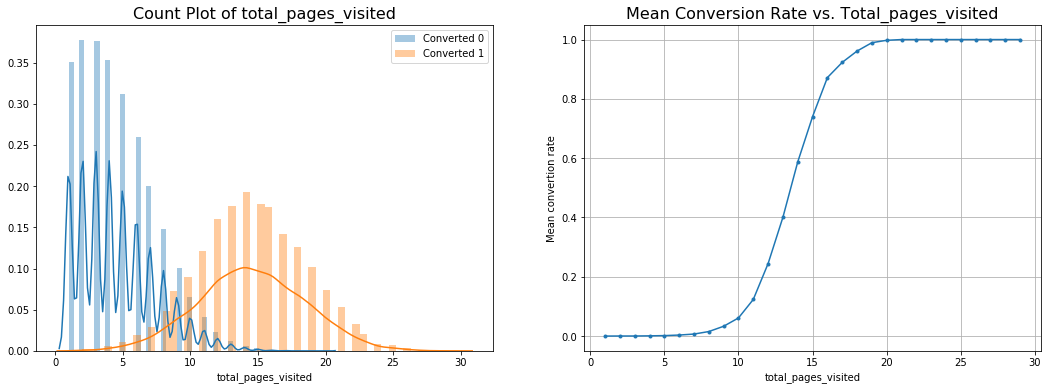

In [11]:
# Visualization of different sources
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0])
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0])
ax[0].set_title('Count Plot of total_pages_visited', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

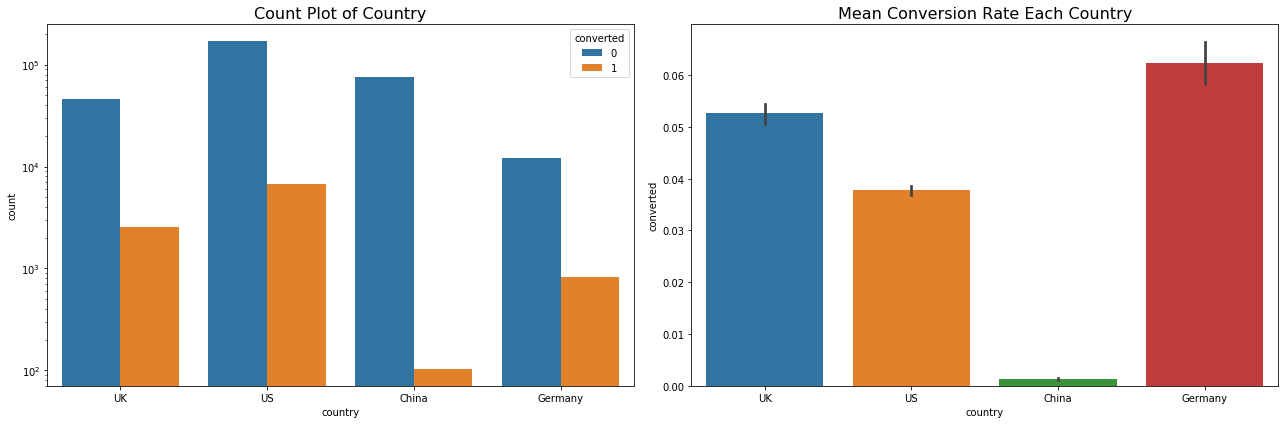

In [13]:
# Visualization of different countries
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate Each Country', fontsize=16)
plt.tight_layout()
plt.show()

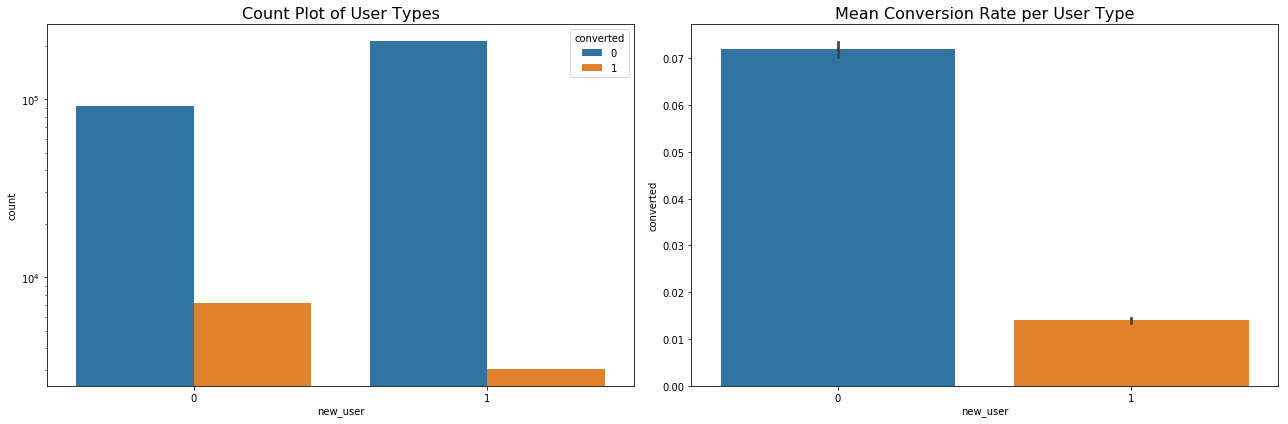

In [14]:
# Visualization of different user types
grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
# Machine Learning
le = preprocessing.LabelEncoder()
label = ['China', 'Germany', 'UK', 'US'] + ['Ads', 'Direct', 'Seo']
le.fit(label)
data['country'] = le.transform(data['country']) 
data['source'] = le.transform(data['source'])

In [16]:
np.random.seed(0)
data['is_train'] = np.random.uniform(0, 1, len(data)) <= .75
train, test = data[data['is_train']==True], data[data['is_train']==False]
feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'
clf = RandomForestClassifier(n_estimators = 100, n_jobs=2, random_state=0)
clf.fit(train[feature], train[target])
pred = clf.predict(test[feature])

In [17]:
# Machine Learning matrics
clf.score(test[feature], test[target])
cm = metrics.confusion_matrix(test[target], pred)
print(cm)

[[76117   385]
 [  884  1725]]


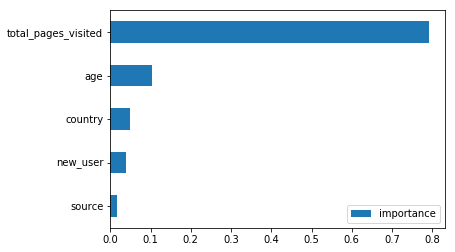

In [18]:
importance = pd.DataFrame(index = feature, data = clf.feature_importances_, columns = ['importance'])
importance.sort_values(by = 'importance', ascending = True, inplace = True)
ax = importance[-5:].plot.barh()

In [19]:
actual = test[target].values
print(classification_report(actual, pred))
fpr, tpr, thresholds = roc_curve(actual, pred)
test_auc = format(metrics.auc(fpr, tpr), '.2f')

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     76502
          1       0.82      0.66      0.73      2609

avg / total       0.98      0.98      0.98     79111



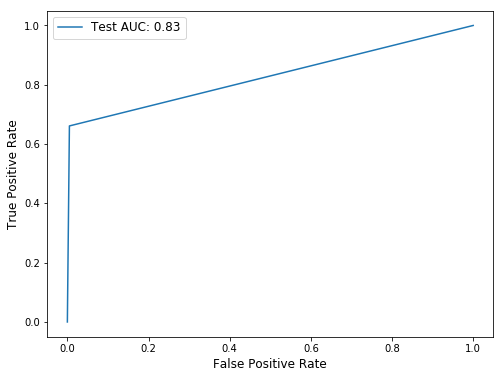

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()